In [52]:
import os
import json
import time
from pathlib import Path
from typing import Any, Dict, Optional

from dotenv import load_dotenv
from langchain_aws import ChatBedrockConverse

# Load environment
load_dotenv("../.env")

MODEL_ID = "us.anthropic.claude-sonnet-4-20250514-v1:0"
llm = ChatBedrockConverse(
    model_id=MODEL_ID,
    region_name=os.getenv("AWS_BEDROCK_REGION"),
    aws_access_key_id=os.getenv("AWS_BEDROCK_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_BEDROCK_SECRET_ACCESS_KEY"),
)

In [53]:
def read_bytes(path: Path) -> bytes:
    return path.read_bytes()


def image_format_from_path(path: Path) -> str:
    s = path.suffix.lower()
    return "png" if s == ".png" else "jpeg"


In [54]:
# Load dataset files
REQUESTS_PATH = Path("data/image-generation-requests.json")
PREDICTIONS_PATH = Path("data/predictions.json")

requests_data = json.loads(REQUESTS_PATH.read_text(encoding="utf-8")) if REQUESTS_PATH.exists() else []
predictions_data = json.loads(PREDICTIONS_PATH.read_text(encoding="utf-8")) if PREDICTIONS_PATH.exists() else {}

len(requests_data), len(predictions_data)

(21, 21)

In [55]:
# Build index of requests by image id (derived from filename stem)
requests_by_id = {}
for rec in requests_data:
    p = Path(rec["imagePath"]).name
    stem = Path(p).stem  # e.g., "1" or "20"
    requests_by_id[stem] = rec

# Helper to get elder/other prediction for an id (if exists)
preds_by_id = {k: v for k, v in predictions_data.items()}

len(requests_by_id), list(requests_by_id.keys())[:5]


(21, ['1', '10', '11', '12', '13'])

In [56]:
# Structured outputs with Pydantic + parallel judges (1–5 integer ratings)
from pydantic import BaseModel, Field
from concurrent.futures import ThreadPoolExecutor

class GroundednessEval(BaseModel):
    grounded_to_image: int = Field(..., ge=1, le=5, description="Grounding to IMAGE (1=poor, 5=excellent)")
    grounded_to_context: int = Field(..., ge=1, le=5, description="Grounding to ADDITIONAL_CONTEXT user instructions (1=poor, 5=excellent)")
    explanation: str = Field(..., description="One-sentence evidence-based explanation")

class QualityEval(BaseModel):
    coherence: int = Field(..., ge=1, le=5, description="Narrative logic and consistency (1=poor, 5=excellent)")
    readability: int = Field(..., ge=1, le=5, description="Clarity and flow (1=poor, 5=excellent)")
    justification: str = Field(..., description="One-sentence justification")

# Structured-output judges
g_judge = llm.with_structured_output(GroundednessEval)
q_judge = llm.with_structured_output(QualityEval)

# Concise prompts
# Note: additional_context are user instructions intended to guide story generation.
def groundedness_messages(image_path: Path, additional_context: str, story_text: str):
    fmt = image_format_from_path(image_path)
    img_bytes = read_bytes(image_path)
    system = (
        "You are an evaluator. Assess how well the STORY is grounded in: (1) the IMAGE, "
        "and (2) the user's instructions used for story generation."
    )
    user = (
        "Return integer ratings 1–5 for grounded_to_image and grounded_to_context, plus a brief explanation."
    )
    story = f"STORY:\n{story_text}"
    ctx = f"(user instructions):\n{additional_context}"
    return [
        {"role": "system", "content": [{"text": system}]},
        {
            "role": "user",
            "content": [
                {"text": user},
                {"image": {"format": fmt, "source": {"bytes": img_bytes}}},
                {"text": ctx},
                {"text": story},
            ],
        },
    ]


def quality_messages(story_text: str):
    system = (
        "You are an evaluator. Assess the STORY for (1) coherence and (2) readability."
    )
    user = "Return integer ratings 1–5 for coherence and readability, plus a brief justification."
    story = f"STORY:\n{story_text}"
    return [
        {"role": "system", "content": [{"text": system}]},
        {"role": "user", "content": [{"text": user}, {"text": story}]},
    ]


def run_groundedness(image_path: Path, additional_context: str, story_text: str):
    return g_judge.invoke(groundedness_messages(image_path, additional_context, story_text)).model_dump()


def run_quality(story_text: str):
    return q_judge.invoke(quality_messages(story_text)).model_dump()


In [57]:
# Run evaluations over items (one thread per record) with progress
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm


def evaluate_one(image_id: str, req: dict):
    req_ctx = req["request"].get("additionalContext", "")
    image_path = Path(req["imagePath"]) if Path(req["imagePath"]).exists() else Path("./") / req["imagePath"]

    pred = preds_by_id.get(image_id)
    story_text = None
    if pred and isinstance(pred, dict):
        story_text = (
            pred.get("story")
            or pred.get("output")
            or pred.get("text")
            or pred.get("elder_check", {}).get("summary")
        )
    if not story_text:
        return None

    grounded = run_groundedness(image_path, req_ctx, story_text)
    quality = run_quality(story_text)

    return {
        "image_id": image_id,
        "image_path": str(image_path),
        "additionalContext": req_ctx,
        "story_word_count": len((story_text or "").split()),
        "grounded": grounded,
        "quality": quality,
    }


results = []
with ThreadPoolExecutor(max_workers=20) as pool:
    futures = [pool.submit(evaluate_one, image_id, req) for image_id, req in requests_by_id.items()]
    for fut in tqdm(as_completed(futures), total=len(futures)):
        r = fut.result()
        if r:
            results.append(r)

len(results)


100%|██████████| 21/21 [00:34<00:00,  1.62s/it]


21

In [58]:
# Save and aggregate metrics
OUT_PATH = Path("data/evaluation-results.json")

if results:
    OUT_PATH.write_text(json.dumps(results, ensure_ascii=False, indent=2), encoding="utf-8")

# Simple aggregates
import statistics as stats

wc = [r["story_word_count"] for r in results]
coh = [r.get("quality", {}).get("coherence", None) for r in results]
read = [r.get("quality", {}).get("readability", None) for r in results]
img_g = [r.get("grounded", {}).get("grounded_to_image", None) for r in results]
ctx_g = [r.get("grounded", {}).get("grounded_to_context", None) for r in results]

# Filter Nones
coh = [x for x in coh if isinstance(x, (int, float))]
read = [x for x in read if isinstance(x, (int, float))]
img_g = [x for x in img_g if isinstance(x, (int, float))]
ctx_g = [x for x in ctx_g if isinstance(x, (int, float))]

aggregates = {
    "num_results": len(results),
    "word_count": {
        "min": min(wc) if wc else None,
        "max": max(wc) if wc else None,
        "mean": float(stats.mean(wc)) if wc else None,
        "median": float(stats.median(wc)) if wc else None,
    },
    "coherence_mean": float(stats.mean(coh)) if coh else None,
    "readability_mean": float(stats.mean(read)) if read else None,
    "grounded_image_mean": float(stats.mean(img_g)) if img_g else None,
    "grounded_context_mean": float(stats.mean(ctx_g)) if ctx_g else None,
}

print("Evaluation Results Summary")
print("=" * 30)
print(f"Number of results: {aggregates['num_results']}")
print("Word count:")
print(f"  Min:    {aggregates['word_count']['min']}")
print(f"  Max:    {aggregates['word_count']['max']}")
print(f"  Mean:   {aggregates['word_count']['mean']:.2f}")
print(f"  Median: {aggregates['word_count']['median']:.2f}")
print()
print(f"Coherence mean:          {aggregates['coherence_mean']:.2f}")
print(f"Readability mean:        {aggregates['readability_mean']:.2f}")
print(f"Grounded to image mean:  {aggregates['grounded_image_mean']:.2f}")
print(f"Grounded to context mean:{aggregates['grounded_context_mean']:.2f}")



Evaluation Results Summary
Number of results: 21
Word count:
  Min:    270
  Max:    547
  Mean:   419.29
  Median: 422.00

Coherence mean:          3.81
Readability mean:        4.14
Grounded to image mean:  3.86
Grounded to context mean:4.14


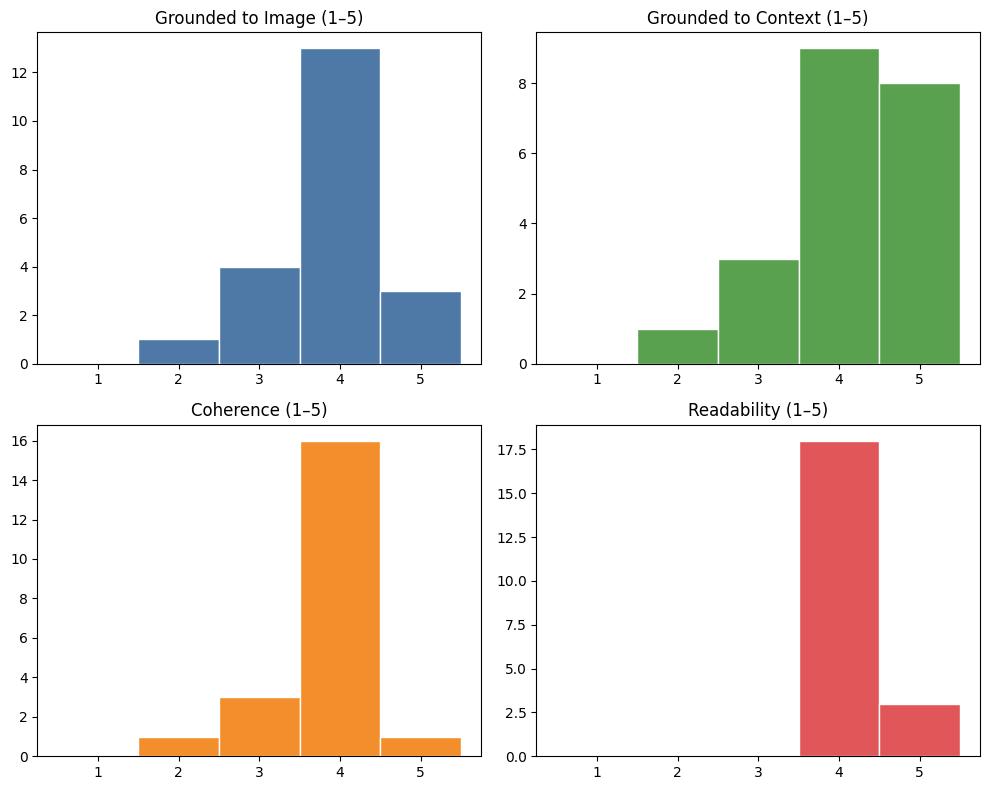

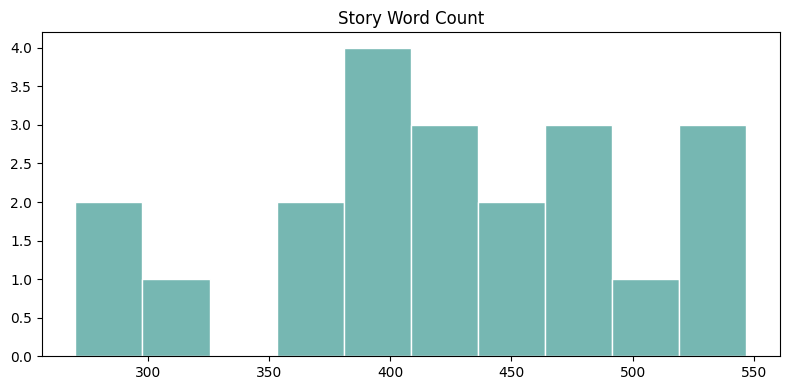

In [59]:
# Visualizations: distributions and simple means (no flavor)
import matplotlib.pyplot as plt
import numpy as np

# Collect score arrays
gi = [r.get("grounded", {}).get("grounded_to_image") for r in results]
gc = [r.get("grounded", {}).get("grounded_to_context") for r in results]
co = [r.get("quality", {}).get("coherence") for r in results]
rd = [r.get("quality", {}).get("readability") for r in results]
wc = [r.get("story_word_count", 0) for r in results]

# Filter out None
gi = [x for x in gi if isinstance(x, (int, float))]
gc = [x for x in gc if isinstance(x, (int, float))]
co = [x for x in co if isinstance(x, (int, float))]
rd = [x for x in rd if isinstance(x, (int, float))]

# Histograms (1–5 scores; word count separate)
bins_1_5 = np.arange(0.5, 6, 1)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

axes[0].hist(gi, bins=bins_1_5, color="#4e79a7", edgecolor="white")
axes[0].set_title("Grounded to Image (1–5)")
axes[0].set_xticks([1, 2, 3, 4, 5])

axes[1].hist(gc, bins=bins_1_5, color="#59a14f", edgecolor="white")
axes[1].set_title("Grounded to Context (1–5)")
axes[1].set_xticks([1, 2, 3, 4, 5])

axes[2].hist(co, bins=bins_1_5, color="#f28e2b", edgecolor="white")
axes[2].set_title("Coherence (1–5)")
axes[2].set_xticks([1, 2, 3, 4, 5])

axes[3].hist(rd, bins=bins_1_5, color="#e15759", edgecolor="white")
axes[3].set_title("Readability (1–5)")
axes[3].set_xticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

# Word count histogram
plt.figure(figsize=(8, 4))
plt.hist(wc, bins=10, color="#76b7b2", edgecolor="white")
plt.title("Story Word Count")
plt.tight_layout()
plt.show()
